### Repeated Prisioner's Dilemma - Double Agent w/o discounting or state or Experience replay

- There are two agents that interact in repeated prisioner's dilemma. 
- Actions are: defect (D/0) or cooperate (C/1).
- Defect is dominant strategy, and (D,D) is Nash Eqbm of stage game. 
- Sustained Cooperation is best for everyone in repeated game. 
- Rewards for agents are 

    - (1,1) for (D,D) 
    - (3,0) for (D,C) 
    - (0,3) for (C,D) 
    - (2.5,2.5) for (C,C)

- There is just one state that does not change. State does not play a role here, it is just a placeholder. 
- There is no "discounting". Agents only value current profits - they do not seek to maximize discounted sum. 

### Import Packages

In [89]:
from itertools import count
import torch
import math
import torch.optim as optim 
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (30, 10)
plt.rcParams['font.size']=20

### Helper Functions

In [90]:
def gameReward(a1,a2):
    if (a1 == 0 and a2 == 0): # DD
        return (0.1,0.1)
    if (a1 == 0 and a2 == 1): # DC
        return (3,0)
    if (a1 == 1 and a2 == 0): # CD
        return (0,3)
    if (a1 == 1 and a2 == 1): # CC
        return (2.5,2.5)
    
import random
from collections import namedtuple, deque
Transition = namedtuple('Transition',('state','next_state','a1','a2','r1','r2'))

class ReplayMemory(object):
    # Holds transitions from experience and gives a random batch of transitions for training
    def __init__(self,capacity):
        self.memory = deque([], maxlen=capacity)
        
    def push(self,*args):
        "save transition"
        self.memory.append(Transition(*args))
        
    def sample(self, batch_size):
        #return random.sample(self.memory, batch_size)
        #return random.sample(list(itertools.islice(self.memory, 0, 128)), batch_size)
        self.memory.rotate(-batch_size)
        return random.sample(deque(self.memory, maxlen=batch_size), batch_size)
        self.memory.rotate(batch_size)
        
    def __len__(self):
        return len(self.memory)

class DQN(nn.Module):
    # Input: State
    # Output: 0,1
    # Network is going to try to predict the expected Return of taking each action given the INPUT
    def __init__(self, n_obs, n_actions):
        super(DQN,self).__init__()
        self.layer1 = nn.Linear(n_obs, 128)
        self.layer2 = nn.Linear(128,128)
        self.layer3 = nn.Linear(128, n_actions)
    
    def forward(self,x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        return self.layer3(x)   


def select_action(state, policy_net, idx):
    # Given state selects action either from the DQN or randomly. 
    global steps_done1, steps_done2
    sample = random.random()
    if idx == 0:
        eps_threshold = EPS_END + (EPS_START-EPS_END)*math.exp(-1.*steps_done1/EPS_DECAY)
        steps_done1 += 1
    else:
        eps_threshold = EPS_END + (EPS_START-EPS_END)*math.exp(-1.*steps_done2/EPS_DECAY)
        steps_done2 += 1
    
    if sample>eps_threshold:
        with torch.no_grad():
            try: 
                return policy_net(state).max(1)[1].view(1,1) # pick up action with largest expected reward
            except:
                return policy_net(state).max(0)[1].view(1,1) # pick up action with largest expected reward
    else:
        randchoice = random.choice([0,1])
        return torch.tensor([[randchoice]],dtype=torch.long)
    
def update_target_net(target_net, policy_net):
    target_net_state_dict = target_net.state_dict()
    policy_net_state_dict = policy_net.state_dict()
    for key in policy_net_state_dict:
        target_net_state_dict[key] = policy_net_state_dict[key]*TAU+target_net_state_dict[key]*(1-TAU)
    target_net.load_state_dict(target_net_state_dict)

def optimize_model(policy_net,target_net,idx):
    if len(memory)<BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    batch = Transition(*zip(*transitions))
    
    # final state is after simulation is done
    # these are the "s(t+1)" from the transitions
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None, batch.next_state)),dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state if s is not None])
    
    # we begin with a batch of transitions - (state, action, reward)
    state_batch = torch.cat(batch.state)

    if idx == 0:
        action_batch = torch.cat(batch.a1)
        reward_batch = torch.cat(batch.r1)
    elif idx == 1:
        action_batch = torch.cat(batch.a2)
        reward_batch = torch.cat(batch.r2)
    
    # For these batch states we compute optimal policy according to our policy-network
    # Compute Q(s,a) and get actions - these are the actions that would have been taken for each batch state 
    state_action_values = policy_net(state_batch.reshape(-1,1)).gather(1,action_batch)
    
    # Compute V(s_t+1)
    next_state_values = torch.zeros(BATCH_SIZE)
    with torch.no_grad():
        # Use the "old" target_net to obtain value (Expected Return) on optimal actions from sampled s(t+1)
        # This is Q_old(s',a')
        next_state_values[non_final_mask] = target_net(non_final_next_states.reshape(-1,1)).max(1)[0]
        
    # Here we have add r + max Q_old(s',a')
    expected_state_action_values = (next_state_values*GAMMA)+reward_batch

    # Compute the loss
    # Q_new(s,a) - r + max Q_old(s',a'): is the error
    # Huber loss function
    criterion = nn.SmoothL1Loss()
    loss = criterion(state_action_values,expected_state_action_values.unsqueeze(1))
    if idx == 0:
        optimizer1.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_value_(policy_net1.parameters(),100)
        optimizer1.step()
    elif idx == 1:
        optimizer2.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_value_(policy_net2.parameters(),100)
        optimizer2.step()
    print(f'Loss Agent{idx}:{loss.item()}')

### HyperParameters and Initializations

In [91]:
BATCH_SIZE = 4 # number of transitions sampled from replay buffer
GAMMA = 0 # Discount factor
EPS_START = 0.5 # Initial value of Epsilon
EPS_END = 0.05 # End value of Epsilon
EPS_DECAY = 2000 # controls decay rate of Epsilon
TAU = 1 # update rate of target network
LR = 0.01 # Learning rate of Adam
n_obs = 1
n_actions = 2
policy_net1 = DQN(n_obs,n_actions)
target_net1 = DQN(n_obs,n_actions)
policy_net2 = DQN(n_obs,n_actions)
target_net2 = DQN(n_obs,n_actions)
steps_done1 = 0
steps_done2 = 0
optimizer1 = optim.AdamW(policy_net1.parameters(),lr=LR,amsgrad=True)
optimizer2 = optim.AdamW(policy_net2.parameters(),lr=LR,amsgrad=True)
memory=ReplayMemory(10000)

### Training Loop

In [92]:
state = torch.tensor(1,dtype=torch.float32).unsqueeze(0)
actions = []
epochs = 10000
for t in range(epochs):
    print('\n Iteration:',t)
    # Take action
    a1 = select_action(state, policy_net1, 0)
    a2 = select_action(state, policy_net2, 1)

    # Obtain Rewards
    r1, r2 = gameReward(int(a1),int(a2))
    r1 = torch.tensor([r1])
    r2 = torch.tensor([r2])

    # Compute next state
    next_state = torch.tensor(1,dtype=torch.float32).unsqueeze(0)

    # store memory in transition
    memory.push(state,next_state,a1,a2,r1,r2)

    # move to next state
    state = next_state

    # optimize
    optimize_model(policy_net1,target_net1, 0)
    optimize_model(policy_net2,target_net2, 1)

    # soft update target_net
    update_target_net(target_net1, policy_net1)
    update_target_net(target_net2, policy_net2)
    
    # record actions
    actions.append([a1.item(),a2.item()])
    
    with torch.no_grad():
        print(policy_net1(state), policy_net2(state))


 Iteration: 0
tensor([-0.0044,  0.1355]) tensor([ 0.0329, -0.0276])

 Iteration: 1
tensor([-0.0044,  0.1355]) tensor([ 0.0329, -0.0276])

 Iteration: 2
tensor([-0.0044,  0.1355]) tensor([ 0.0329, -0.0276])

 Iteration: 3
Loss Agent0:1.09681236743927
Loss Agent1:1.7405281066894531
tensor([1.0010, 0.5267]) tensor([0.9972, 0.5338])

 Iteration: 4
Loss Agent0:0.812435507774353
Loss Agent1:0.878490149974823
tensor([2.0148, 0.8290]) tensor([1.7079, 1.2787])

 Iteration: 5
Loss Agent0:0.6468240022659302
Loss Agent1:0.9322859048843384
tensor([2.6526, 0.4256]) tensor([1.7299, 2.1674])

 Iteration: 6
Loss Agent0:0.9444713592529297
Loss Agent1:1.3086767196655273
tensor([2.6818, 0.2641]) tensor([1.5628, 1.9783])

 Iteration: 7
Loss Agent0:0.9718489050865173
Loss Agent1:1.349424123764038
tensor([2.3194, 0.2257]) tensor([1.1774, 1.4393])

 Iteration: 8
Loss Agent0:0.8861666917800903
Loss Agent1:0.8488668203353882
tensor([1.8230, 0.2566]) tensor([0.7943, 0.8445])

 Iteration: 9
Loss Agent0:1.0556045

Loss Agent1:0.6376012563705444
tensor([0.5299, 0.1792]) tensor([0.7513, 0.8428])

 Iteration: 74
Loss Agent0:1.0312421321868896
Loss Agent1:1.0161616802215576
tensor([0.6218, 0.2043]) tensor([0.7376, 0.8283])

 Iteration: 75
Loss Agent0:0.13614881038665771
Loss Agent1:0.6629161238670349
tensor([0.6482, 0.2180]) tensor([0.7159, 0.7836])

 Iteration: 76
Loss Agent0:0.05539374053478241
Loss Agent1:0.6469658613204956
tensor([0.6532, 0.2132]) tensor([0.6886, 0.7174])

 Iteration: 77
Loss Agent0:1.3757562637329102
Loss Agent1:0.8601117134094238
tensor([0.7199, 0.2358]) tensor([0.6698, 0.6768])

 Iteration: 78
Loss Agent0:0.15103739500045776
Loss Agent1:0.1789928823709488
tensor([0.7212, 0.2416]) tensor([0.6154, 0.6153])

 Iteration: 79
Loss Agent0:0.9807701110839844
Loss Agent1:1.1967074871063232
tensor([0.7197, 0.2701]) tensor([0.5925, 0.5980])

 Iteration: 80
Loss Agent0:0.5501970052719116
Loss Agent1:1.5283803939819336
tensor([0.7093, 0.2877]) tensor([0.6123, 0.6361])

 Iteration: 81
Loss

Loss Agent0:0.9960653781890869
Loss Agent1:0.5090938806533813
tensor([1.6377, 1.9570]) tensor([0.7218, 0.6627])

 Iteration: 149
Loss Agent0:0.7712787389755249
Loss Agent1:0.49244746565818787
tensor([1.7006, 1.9853]) tensor([0.6830, 0.6217])

 Iteration: 150
Loss Agent0:0.9547265768051147
Loss Agent1:0.4836934506893158
tensor([1.6568, 1.9281]) tensor([0.6401, 0.5804])

 Iteration: 151
Loss Agent0:0.9500000476837158
Loss Agent1:0.9040806293487549
tensor([1.6180, 1.8774]) tensor([0.6143, 0.5479])

 Iteration: 152
Loss Agent0:0.8678013682365417
Loss Agent1:0.46223166584968567
tensor([1.5739, 1.8119]) tensor([0.5781, 0.5224])

 Iteration: 153
Loss Agent0:1.1428987979888916
Loss Agent1:0.13092105090618134
tensor([1.4157, 1.6123]) tensor([0.5346, 0.4838])

 Iteration: 154
Loss Agent0:0.7461482882499695
Loss Agent1:1.5032742023468018
tensor([1.3298, 1.4975]) tensor([0.5253, 0.4580])

 Iteration: 155
Loss Agent0:0.5593641996383667
Loss Agent1:1.399067997932434
tensor([1.2833, 1.4965]) tensor([

Loss Agent0:1.497678518295288
Loss Agent1:1.2740380764007568
tensor([2.4958, 0.8371]) tensor([1.0850, 0.8797])

 Iteration: 220
Loss Agent0:0.23875412344932556
Loss Agent1:1.182536244392395
tensor([2.4697, 0.8025]) tensor([1.1229, 0.9031])

 Iteration: 221
Loss Agent0:1.3655674457550049
Loss Agent1:1.023470163345337
tensor([2.4251, 0.8257]) tensor([1.1738, 0.9538])

 Iteration: 222
Loss Agent0:0.2530587315559387
Loss Agent1:0.9202593564987183
tensor([2.4273, 0.8239]) tensor([1.2318, 0.9946])

 Iteration: 223
Loss Agent0:0.7139157652854919
Loss Agent1:0.7222903966903687
tensor([2.4727, 0.8537]) tensor([1.2673, 0.9993])

 Iteration: 224
Loss Agent0:0.44719773530960083
Loss Agent1:0.7920007705688477
tensor([2.5732, 0.8970]) tensor([1.2881, 1.0108])

 Iteration: 225
Loss Agent0:0.7950363755226135
Loss Agent1:0.8943234086036682
tensor([2.5750, 0.8623]) tensor([1.2952, 1.0288])

 Iteration: 226
Loss Agent0:0.8936988115310669
Loss Agent1:0.6120005249977112
tensor([2.5459, 0.8279]) tensor([1.2

Loss Agent0:0.7237635850906372
Loss Agent1:1.2026879787445068
tensor([0.9892, 0.4239]) tensor([0.8812, 0.8653])

 Iteration: 292
Loss Agent0:0.5978310108184814
Loss Agent1:0.5298217535018921
tensor([0.9351, 0.4183]) tensor([0.8952, 0.8701])

 Iteration: 293
Loss Agent0:1.2039728164672852
Loss Agent1:0.5351857542991638
tensor([0.9060, 0.4255]) tensor([0.8928, 0.8683])

 Iteration: 294
Loss Agent0:0.5249629020690918
Loss Agent1:1.1807427406311035
tensor([0.8795, 0.4275]) tensor([0.9110, 0.8775])

 Iteration: 295
Loss Agent0:0.19760140776634216
Loss Agent1:0.8563426733016968
tensor([0.8349, 0.4183]) tensor([0.9300, 0.8881])

 Iteration: 296
Loss Agent0:1.2498629093170166
Loss Agent1:1.0345876216888428
tensor([0.8199, 0.4203]) tensor([0.9590, 0.9211])

 Iteration: 297
Loss Agent0:1.2997432947158813
Loss Agent1:0.9549728631973267
tensor([0.8242, 0.4322]) tensor([0.9887, 0.9530])

 Iteration: 298
Loss Agent0:0.91499924659729
Loss Agent1:1.2469899654388428
tensor([0.8198, 0.4485]) tensor([1.0

Loss Agent0:0.1898687183856964
Loss Agent1:0.5772814750671387
tensor([0.6661, 0.6133]) tensor([0.6637, 0.4246])

 Iteration: 362
Loss Agent0:0.8991854190826416
Loss Agent1:0.9151788949966431
tensor([0.7134, 0.5834]) tensor([0.6722, 0.4322])

 Iteration: 363
Loss Agent0:0.8948719501495361
Loss Agent1:0.5445659160614014
tensor([0.7449, 0.5779]) tensor([0.6807, 0.4362])

 Iteration: 364
Loss Agent0:0.9815320372581482
Loss Agent1:0.5445485711097717
tensor([0.8040, 0.5697]) tensor([0.6889, 0.4369])

 Iteration: 365
Loss Agent0:0.2050536423921585
Loss Agent1:0.15391595661640167
tensor([0.7964, 0.5428]) tensor([0.6852, 0.4320])

 Iteration: 366
Loss Agent0:0.9730464220046997
Loss Agent1:0.5431699752807617
tensor([0.8122, 0.5148]) tensor([0.6824, 0.4248])

 Iteration: 367
Loss Agent0:0.8897877931594849
Loss Agent1:1.6964194774627686
tensor([0.8344, 0.5003]) tensor([0.6955, 0.4308])

 Iteration: 368
Loss Agent0:0.5410521626472473
Loss Agent1:0.5252869129180908
tensor([0.8032, 0.5090]) tensor([0

Loss Agent0:1.0532689094543457
Loss Agent1:0.7780940532684326
tensor([0.4845, 0.4449]) tensor([1.1338, 0.9270])

 Iteration: 431
Loss Agent0:1.0446985960006714
Loss Agent1:0.9500000476837158
tensor([0.4932, 0.4434]) tensor([1.1291, 0.9252])

 Iteration: 432
Loss Agent0:0.4471295475959778
Loss Agent1:0.8506999611854553
tensor([0.4988, 0.4441]) tensor([1.1252, 0.9242])

 Iteration: 433
Loss Agent0:1.8898499011993408
Loss Agent1:0.8752431869506836
tensor([0.5183, 0.4570]) tensor([1.1156, 0.9290])

 Iteration: 434
Loss Agent0:0.5695027709007263
Loss Agent1:0.949999988079071
tensor([0.5364, 0.4654]) tensor([1.1070, 0.9332])

 Iteration: 435
Loss Agent0:0.9221699833869934
Loss Agent1:0.6290756464004517
tensor([0.5561, 0.4785]) tensor([1.0787, 0.9282])

 Iteration: 436
Loss Agent0:1.0239664316177368
Loss Agent1:0.4669104218482971
tensor([0.5791, 0.4932]) tensor([1.0208, 0.9009])

 Iteration: 437
Loss Agent0:1.0178258419036865
Loss Agent1:0.41943854093551636
tensor([0.6054, 0.5094]) tensor([0.

Loss Agent0:0.508032500743866
Loss Agent1:0.16362646222114563
tensor([0.4972, 0.2220]) tensor([0.5430, 0.6237])

 Iteration: 501
Loss Agent0:0.49010878801345825
Loss Agent1:1.2259998321533203
tensor([0.4811, 0.2211]) tensor([0.5535, 0.6089])

 Iteration: 502
Loss Agent0:0.9737180471420288
Loss Agent1:1.5299382209777832
tensor([0.4699, 0.2225]) tensor([0.5955, 0.6264])

 Iteration: 503
Loss Agent0:1.0383334159851074
Loss Agent1:1.0319712162017822
tensor([0.4653, 0.2252]) tensor([0.6709, 0.6492])

 Iteration: 504
Loss Agent0:0.5380263328552246
Loss Agent1:0.1748889535665512
tensor([0.4628, 0.2273]) tensor([0.6585, 0.6349])

 Iteration: 505
Loss Agent0:0.9753920435905457
Loss Agent1:1.0742157697677612
tensor([0.4633, 0.2313]) tensor([0.6605, 0.6614])

 Iteration: 506
Loss Agent0:0.5390505194664001
Loss Agent1:0.8884735107421875
tensor([0.4653, 0.2347]) tensor([0.6770, 0.6982])

 Iteration: 507
Loss Agent0:1.031112790107727
Loss Agent1:1.4282195568084717
tensor([0.4730, 0.2388]) tensor([0.

Loss Agent0:0.168221116065979
Loss Agent1:1.3014016151428223
tensor([0.7578, 0.5612]) tensor([0.6855, 0.7232])

 Iteration: 574
Loss Agent0:1.6663787364959717
Loss Agent1:0.21645581722259521
tensor([0.7922, 0.5770]) tensor([0.6941, 0.7249])

 Iteration: 575
Loss Agent0:0.5700847506523132
Loss Agent1:0.6484969258308411
tensor([0.8231, 0.5855]) tensor([0.7020, 0.7173])

 Iteration: 576
Loss Agent0:1.2574145793914795
Loss Agent1:0.8797985315322876
tensor([0.8630, 0.6026]) tensor([0.7111, 0.7125])

 Iteration: 577
Loss Agent0:0.9640421271324158
Loss Agent1:0.8624564409255981
tensor([0.9035, 0.6195]) tensor([0.7203, 0.7127])

 Iteration: 578
Loss Agent0:0.6412464380264282
Loss Agent1:0.862935483455658
tensor([0.9303, 0.6307]) tensor([0.7295, 0.7174])

 Iteration: 579
Loss Agent0:0.5780518054962158
Loss Agent1:1.3773906230926514
tensor([0.9522, 0.6328]) tensor([0.7481, 0.7262])

 Iteration: 580
Loss Agent0:0.8695802688598633
Loss Agent1:1.5128467082977295
tensor([0.9747, 0.6376]) tensor([0.7

tensor([0.6020, 0.4959]) tensor([0.5694, 0.4527])

 Iteration: 639
Loss Agent0:1.011246681213379
Loss Agent1:0.8268212080001831
tensor([0.6155, 0.5087]) tensor([0.5731, 0.4570])

 Iteration: 640
Loss Agent0:1.6879103183746338
Loss Agent1:0.5619074106216431
tensor([0.6394, 0.5327]) tensor([0.5768, 0.4590])

 Iteration: 641
Loss Agent0:0.9029237627983093
Loss Agent1:0.9208095073699951
tensor([0.6657, 0.5566]) tensor([0.5819, 0.4627])

 Iteration: 642
Loss Agent0:1.4144384860992432
Loss Agent1:1.4653615951538086
tensor([0.7028, 0.5819]) tensor([0.5934, 0.4677])

 Iteration: 643
Loss Agent0:0.5855681896209717
Loss Agent1:1.2701616287231445
tensor([0.7335, 0.6036]) tensor([0.6080, 0.4772])

 Iteration: 644
Loss Agent0:0.1868063509464264
Loss Agent1:1.0067423582077026
tensor([0.7544, 0.6120]) tensor([0.6248, 0.4862])

 Iteration: 645
Loss Agent0:0.583568274974823
Loss Agent1:1.3456058502197266
tensor([0.7725, 0.6134]) tensor([0.6463, 0.4980])

 Iteration: 646
Loss Agent0:1.2669461965560913
L

Loss Agent0:0.47059202194213867
Loss Agent1:0.9327583312988281
tensor([0.6128, 0.4918]) tensor([0.5616, 0.3935])

 Iteration: 716
Loss Agent0:1.258784532546997
Loss Agent1:0.5499503016471863
tensor([0.6161, 0.5033]) tensor([0.5629, 0.3949])

 Iteration: 717
Loss Agent0:0.5692306160926819
Loss Agent1:0.5573411583900452
tensor([0.6183, 0.5118]) tensor([0.5639, 0.3954])

 Iteration: 718
Loss Agent0:0.5694876909255981
Loss Agent1:0.10759588330984116
tensor([0.6204, 0.5161]) tensor([0.5608, 0.3944])

 Iteration: 719
Loss Agent0:1.00694739818573
Loss Agent1:0.8487668037414551
tensor([0.6270, 0.5201]) tensor([0.5581, 0.3966])

 Iteration: 720
Loss Agent0:1.3411916494369507
Loss Agent1:0.9322124123573303
tensor([0.6402, 0.5302]) tensor([0.5574, 0.4003])

 Iteration: 721
Loss Agent0:0.5716949105262756
Loss Agent1:0.46613335609436035
tensor([0.6524, 0.5356]) tensor([0.5558, 0.4036])

 Iteration: 722
Loss Agent0:1.3257842063903809
Loss Agent1:1.0128203630447388
tensor([0.6724, 0.5458]) tensor([0.

Loss Agent0:0.5710654854774475
Loss Agent1:0.5663536190986633
tensor([0.6140, 0.4072]) tensor([0.5647, 0.4546])

 Iteration: 790
Loss Agent0:0.5459738969802856
Loss Agent1:1.4784646034240723
tensor([0.6114, 0.4053]) tensor([0.5570, 0.4504])

 Iteration: 791
Loss Agent0:0.9362195134162903
Loss Agent1:0.10368739813566208
tensor([0.6101, 0.4063]) tensor([0.5470, 0.4444])

 Iteration: 792
Loss Agent0:1.0099945068359375
Loss Agent1:1.7542743682861328
tensor([0.6122, 0.4084]) tensor([0.5437, 0.4453])

 Iteration: 793
Loss Agent0:0.47239166498184204
Loss Agent1:0.562900722026825
tensor([0.6125, 0.4101]) tensor([0.5400, 0.4458])

 Iteration: 794
Loss Agent0:0.472354531288147
Loss Agent1:0.0974564477801323
tensor([0.6113, 0.4117]) tensor([0.5338, 0.4442])

 Iteration: 795
Loss Agent0:0.10773307085037231
Loss Agent1:0.46065205335617065
tensor([0.6059, 0.4096]) tensor([0.5269, 0.4435])

 Iteration: 796
Loss Agent0:0.5695064663887024
Loss Agent1:0.09292048215866089
tensor([0.5995, 0.4072]) tensor(

Loss Agent0:0.12461031973361969
Loss Agent1:0.5950378179550171
tensor([0.6374, 0.2741]) tensor([0.7670, 0.8220])

 Iteration: 859
Loss Agent0:1.3988655805587769
Loss Agent1:1.3842339515686035
tensor([0.6279, 0.2750]) tensor([0.7972, 0.8439])

 Iteration: 860
Loss Agent0:0.08859235793352127
Loss Agent1:0.2430146187543869
tensor([0.6160, 0.2740]) tensor([0.8125, 0.8578])

 Iteration: 861
Loss Agent0:0.9295543432235718
Loss Agent1:0.28236910700798035
tensor([0.6036, 0.2767]) tensor([0.8147, 0.8604])

 Iteration: 862
Loss Agent0:0.4816649258136749
Loss Agent1:0.6415687203407288
tensor([0.5913, 0.2796]) tensor([0.8127, 0.8567])

 Iteration: 863
Loss Agent0:0.07990143448114395
Loss Agent1:0.6688051223754883
tensor([0.5775, 0.2805]) tensor([0.8083, 0.8439])

 Iteration: 864
Loss Agent0:0.9995718002319336
Loss Agent1:1.1975871324539185
tensor([0.5693, 0.2818]) tensor([0.8124, 0.8411])

 Iteration: 865
Loss Agent0:1.0204168558120728
Loss Agent1:0.9706828594207764
tensor([0.5648, 0.2837]) tensor

Loss Agent0:1.4199318885803223
Loss Agent1:0.9536299705505371
tensor([0.5365, 0.3716]) tensor([0.4093, 0.4050])

 Iteration: 924
Loss Agent0:1.0293737649917603
Loss Agent1:0.056370995938777924
tensor([0.5516, 0.3795]) tensor([0.4087, 0.4016])

 Iteration: 925
Loss Agent0:1.0251774787902832
Loss Agent1:0.9627552628517151
tensor([0.5682, 0.3876]) tensor([0.4094, 0.3993])

 Iteration: 926
Loss Agent0:0.565157949924469
Loss Agent1:0.4360736012458801
tensor([0.5824, 0.3946]) tensor([0.4092, 0.3986])

 Iteration: 927
Loss Agent0:0.10674476623535156
Loss Agent1:1.0692949295043945
tensor([0.5912, 0.3990]) tensor([0.4107, 0.3984])

 Iteration: 928
Loss Agent0:0.5574195981025696
Loss Agent1:1.5790174007415771
tensor([0.5989, 0.4020]) tensor([0.4153, 0.3991])

 Iteration: 929
Loss Agent0:0.5686070919036865
Loss Agent1:0.5659393072128296
tensor([0.6044, 0.4043]) tensor([0.4198, 0.3992])

 Iteration: 930
Loss Agent0:0.8614722490310669
Loss Agent1:1.9603434801101685
tensor([0.6082, 0.4105]) tensor([

tensor([0.5229, 0.4724]) tensor([0.5511, 0.3750])

 Iteration: 992
Loss Agent0:0.5668866634368896
Loss Agent1:0.5635346174240112
tensor([0.5202, 0.4751]) tensor([0.5465, 0.3707])

 Iteration: 993
Loss Agent0:0.9203280210494995
Loss Agent1:0.08418503403663635
tensor([0.5190, 0.4802]) tensor([0.5407, 0.3651])

 Iteration: 994
Loss Agent0:0.9190961718559265
Loss Agent1:0.08948005735874176
tensor([0.5190, 0.4876]) tensor([0.5333, 0.3589])

 Iteration: 995
Loss Agent0:0.10333120822906494
Loss Agent1:0.45857879519462585
tensor([0.5164, 0.4910]) tensor([0.5268, 0.3533])

 Iteration: 996
Loss Agent0:0.5693829655647278
Loss Agent1:0.07674145698547363
tensor([0.5140, 0.4928]) tensor([0.5195, 0.3467])

 Iteration: 997
Loss Agent0:0.09464044868946075
Loss Agent1:0.06707507371902466
tensor([0.5088, 0.4921]) tensor([0.5119, 0.3390])

 Iteration: 998
Loss Agent0:0.08357705920934677
Loss Agent1:0.08485054969787598
tensor([0.5008, 0.4902]) tensor([0.5030, 0.3315])

 Iteration: 999
Loss Agent0:1.0397586

Loss Agent0:1.3422329425811768
Loss Agent1:0.4996659755706787
tensor([0.6164, 0.5156]) tensor([0.5360, 0.2916])

 Iteration: 1062
Loss Agent0:0.8088928461074829
Loss Agent1:1.4328545331954956
tensor([0.6114, 0.5123]) tensor([0.5343, 0.2928])

 Iteration: 1063
Loss Agent0:1.0096856355667114
Loss Agent1:1.0171563625335693
tensor([0.6094, 0.5103]) tensor([0.5348, 0.2938])

 Iteration: 1064
Loss Agent0:0.9099454879760742
Loss Agent1:0.9651031494140625
tensor([0.6084, 0.5113]) tensor([0.5357, 0.2964])

 Iteration: 1065
Loss Agent0:0.12925758957862854
Loss Agent1:0.4843442142009735
tensor([0.6024, 0.5105]) tensor([0.5356, 0.2995])

 Iteration: 1066
Loss Agent0:0.5690532326698303
Loss Agent1:0.49627330899238586
tensor([0.5958, 0.5092]) tensor([0.5340, 0.3034])

 Iteration: 1067
Loss Agent0:0.12626688182353973
Loss Agent1:0.9627284407615662
tensor([0.5865, 0.5044]) tensor([0.5330, 0.3086])

 Iteration: 1068
Loss Agent0:0.569348156452179
Loss Agent1:0.4816317558288574
tensor([0.5780, 0.4988]) t

Loss Agent0:0.5871025323867798
Loss Agent1:1.0389293432235718
tensor([0.7862, 0.5760]) tensor([0.5052, 0.4205])

 Iteration: 1131
Loss Agent0:0.4978034496307373
Loss Agent1:0.8323842883110046
tensor([0.7872, 0.5754]) tensor([0.5067, 0.4268])

 Iteration: 1132
Loss Agent0:0.5876399278640747
Loss Agent1:1.0400900840759277
tensor([0.7858, 0.5720]) tensor([0.5100, 0.4322])

 Iteration: 1133
Loss Agent0:0.9031258821487427
Loss Agent1:0.08405798673629761
tensor([0.7844, 0.5723]) tensor([0.5108, 0.4366])

 Iteration: 1134
Loss Agent0:0.9572844505310059
Loss Agent1:0.08710402995347977
tensor([0.7876, 0.5721]) tensor([0.5097, 0.4392])

 Iteration: 1135
Loss Agent0:0.5508526563644409
Loss Agent1:1.0402610301971436
tensor([0.7921, 0.5669]) tensor([0.5106, 0.4413])

 Iteration: 1136
Loss Agent0:0.20010799169540405
Loss Agent1:1.0401170253753662
tensor([0.7891, 0.5561]) tensor([0.5135, 0.4430])

 Iteration: 1137
Loss Agent0:0.19600555300712585
Loss Agent1:0.5670679807662964
tensor([0.7794, 0.5406])

Loss Agent0:0.4493260085582733
Loss Agent1:0.5523648858070374
tensor([0.5321, 0.5474]) tensor([0.5967, 0.3457])

 Iteration: 1202
Loss Agent0:0.5619938373565674
Loss Agent1:0.4901835322380066
tensor([0.5244, 0.5494]) tensor([0.5960, 0.3473])

 Iteration: 1203
Loss Agent0:0.5918619632720947
Loss Agent1:0.1230214312672615
tensor([0.5178, 0.5485]) tensor([0.5924, 0.3480])

 Iteration: 1204
Loss Agent0:1.391568660736084
Loss Agent1:0.07572118192911148
tensor([0.5155, 0.5500]) tensor([0.5881, 0.3466])

 Iteration: 1205
Loss Agent0:0.5771033763885498
Loss Agent1:0.5026950836181641
tensor([0.5133, 0.5500]) tensor([0.5824, 0.3465])

 Iteration: 1206
Loss Agent0:1.9866900444030762
Loss Agent1:0.08820979297161102
tensor([0.5178, 0.5523]) tensor([0.5757, 0.3450])

 Iteration: 1207
Loss Agent0:0.4437040686607361
Loss Agent1:0.5391087532043457
tensor([0.5208, 0.5550]) tensor([0.5702, 0.3426])

 Iteration: 1208
Loss Agent0:0.44402220845222473
Loss Agent1:0.09757790714502335
tensor([0.5223, 0.5581]) 

Loss Agent0:0.0979476347565651
Loss Agent1:0.548738420009613
tensor([0.5365, 0.5655]) tensor([0.4300, 0.2669])

 Iteration: 1265
Loss Agent0:0.11142528057098389
Loss Agent1:0.04974940046668053
tensor([0.5284, 0.5595]) tensor([0.4271, 0.2653])

 Iteration: 1266
Loss Agent0:0.5941059589385986
Loss Agent1:2.0729243755340576
tensor([0.5216, 0.5513]) tensor([0.4287, 0.2645])

 Iteration: 1267
Loss Agent0:0.5612548589706421
Loss Agent1:0.47437140345573425
tensor([0.5151, 0.5437]) tensor([0.4292, 0.2650])

 Iteration: 1268
Loss Agent0:1.035536527633667
Loss Agent1:0.47438251972198486
tensor([0.5112, 0.5376]) tensor([0.4288, 0.2667])

 Iteration: 1269
Loss Agent0:1.03667151927948
Loss Agent1:0.9781537055969238
tensor([0.5097, 0.5327]) tensor([0.4291, 0.2696])

 Iteration: 1270
Loss Agent0:1.2666919231414795
Loss Agent1:1.4816159009933472
tensor([0.5106, 0.5340]) tensor([0.4312, 0.2739])

 Iteration: 1271
Loss Agent0:0.09887800365686417
Loss Agent1:0.5539983510971069
tensor([0.5090, 0.5324]) te

Loss Agent0:1.0077861547470093
Loss Agent1:0.5535474419593811
tensor([0.6018, 0.4722]) tensor([0.5042, 0.3646])

 Iteration: 1334
Loss Agent0:0.5617684125900269
Loss Agent1:0.9486442804336548
tensor([0.5989, 0.4652]) tensor([0.5088, 0.3649])

 Iteration: 1335
Loss Agent0:0.12039763480424881
Loss Agent1:1.0373809337615967
tensor([0.5935, 0.4571]) tensor([0.5144, 0.3655])

 Iteration: 1336
Loss Agent0:0.5636324882507324
Loss Agent1:1.0357301235198975
tensor([0.5885, 0.4489]) tensor([0.5210, 0.3663])

 Iteration: 1337
Loss Agent0:1.3733488321304321
Loss Agent1:0.9421058297157288
tensor([0.5870, 0.4446]) tensor([0.5278, 0.3683])

 Iteration: 1338
Loss Agent0:0.5622487664222717
Loss Agent1:0.09152229130268097
tensor([0.5855, 0.4397]) tensor([0.5318, 0.3695])

 Iteration: 1339
Loss Agent0:0.11256998777389526
Loss Agent1:0.5494916439056396
tensor([0.5816, 0.4337]) tensor([0.5359, 0.3696])

 Iteration: 1340
Loss Agent0:0.566573977470398
Loss Agent1:0.5556029081344604
tensor([0.5773, 0.4282]) t

Loss Agent0:0.06904752552509308
Loss Agent1:0.49502915143966675
tensor([0.4905, 0.3372]) tensor([0.6497, 0.4751])

 Iteration: 1397
Loss Agent0:1.5212979316711426
Loss Agent1:0.1319841593503952
tensor([0.4950, 0.3187]) tensor([0.6458, 0.4720])

 Iteration: 1398
Loss Agent0:0.5529512166976929
Loss Agent1:0.5564770102500916
tensor([0.5019, 0.2894]) tensor([0.6426, 0.4674])

 Iteration: 1399
Loss Agent0:0.9578206539154053
Loss Agent1:0.9832919239997864
tensor([0.5091, 0.2848]) tensor([0.6428, 0.4624])

 Iteration: 1400
Loss Agent0:0.9575762748718262
Loss Agent1:0.9921385049819946
tensor([0.5132, 0.3016]) tensor([0.6453, 0.4576])

 Iteration: 1401
Loss Agent0:1.5114680528640747
Loss Agent1:0.5751840472221375
tensor([0.5249, 0.3002]) tensor([0.6464, 0.4530])

 Iteration: 1402
Loss Agent0:0.561475932598114
Loss Agent1:0.1492835134267807
tensor([0.5342, 0.3013]) tensor([0.6436, 0.4478])

 Iteration: 1403
Loss Agent0:0.08205852657556534
Loss Agent1:0.55117267370224
tensor([0.5367, 0.3073]) ten

Loss Agent0:1.0145317316055298
Loss Agent1:0.9376318454742432
tensor([0.5970, 0.3913]) tensor([0.5001, 0.4094])

 Iteration: 1465
Loss Agent0:1.001527190208435
Loss Agent1:0.08192841708660126
tensor([0.6037, 0.3953]) tensor([0.4945, 0.4066])

 Iteration: 1466
Loss Agent0:0.5448629260063171
Loss Agent1:0.5609519481658936
tensor([0.6102, 0.3976]) tensor([0.4896, 0.4035])

 Iteration: 1467
Loss Agent0:0.13017110526561737
Loss Agent1:0.07865876704454422
tensor([0.6129, 0.3989]) tensor([0.4842, 0.3992])

 Iteration: 1468
Loss Agent0:0.11855166405439377
Loss Agent1:1.3227829933166504
tensor([0.6128, 0.3986]) tensor([0.4805, 0.3987])

 Iteration: 1469
Loss Agent0:1.376835584640503
Loss Agent1:1.045954704284668
tensor([0.6154, 0.4009]) tensor([0.4786, 0.3985])

 Iteration: 1470
Loss Agent0:0.5576476454734802
Loss Agent1:0.07359317690134048
tensor([0.6175, 0.4021]) tensor([0.4754, 0.3975])

 Iteration: 1471
Loss Agent0:0.54453444480896
Loss Agent1:0.5611283779144287
tensor([0.6198, 0.4019]) ten

Loss Agent1:0.5587189197540283
tensor([0.5077, 0.3988]) tensor([0.4614, 0.3586])

 Iteration: 1534
Loss Agent0:0.08040609955787659
Loss Agent1:1.0517069101333618
tensor([0.5075, 0.3973]) tensor([0.4625, 0.3546])

 Iteration: 1535
Loss Agent0:0.9403220415115356
Loss Agent1:0.9528661966323853
tensor([0.5077, 0.3987]) tensor([0.4644, 0.3520])

 Iteration: 1536
Loss Agent0:0.08222059905529022
Loss Agent1:1.0510083436965942
tensor([0.5059, 0.3988]) tensor([0.4674, 0.3499])

 Iteration: 1537
Loss Agent0:0.9393017888069153
Loss Agent1:0.5556399822235107
tensor([0.5053, 0.4006]) tensor([0.4706, 0.3471])

 Iteration: 1538
Loss Agent0:0.5597984194755554
Loss Agent1:1.539191722869873
tensor([0.5050, 0.4010]) tensor([0.4764, 0.3451])

 Iteration: 1539
Loss Agent0:0.4612528383731842
Loss Agent1:0.464036762714386
tensor([0.5028, 0.4042]) tensor([0.4809, 0.3441])

 Iteration: 1540
Loss Agent0:0.08139920979738235
Loss Agent1:0.9550238847732544
tensor([0.4991, 0.4045]) tensor([0.4855, 0.3447])

 Iterat

Loss Agent0:0.5583363175392151
Loss Agent1:0.49411773681640625
tensor([0.4349, 0.3897]) tensor([0.5261, 0.2980])

 Iteration: 1605
Loss Agent0:0.5583342909812927
Loss Agent1:0.48198533058166504
tensor([0.4338, 0.3856]) tensor([0.5249, 0.3003])

 Iteration: 1606
Loss Agent0:0.5629957318305969
Loss Agent1:0.07896976917982101
tensor([0.4331, 0.3814]) tensor([0.5223, 0.3017])

 Iteration: 1607
Loss Agent0:0.4548799991607666
Loss Agent1:1.3549505472183228
tensor([0.4321, 0.3780]) tensor([0.5213, 0.3056])

 Iteration: 1608
Loss Agent0:0.4550074636936188
Loss Agent1:1.0337092876434326
tensor([0.4309, 0.3752]) tensor([0.5218, 0.3092])

 Iteration: 1609
Loss Agent0:0.05866368114948273
Loss Agent1:0.07867475599050522
tensor([0.4288, 0.3719]) tensor([0.5207, 0.3119])

 Iteration: 1610
Loss Agent0:0.45511406660079956
Loss Agent1:1.4337897300720215
tensor([0.4266, 0.3694]) tensor([0.5217, 0.3160])

 Iteration: 1611
Loss Agent0:0.45138323307037354
Loss Agent1:0.4779495894908905
tensor([0.4241, 0.367

Loss Agent1:1.0646940469741821
tensor([0.6110, 0.4712]) tensor([0.4189, 0.3188])

 Iteration: 1673
Loss Agent0:0.13053661584854126
Loss Agent1:1.065962314605713
tensor([0.6022, 0.4678]) tensor([0.4171, 0.3171])

 Iteration: 1674
Loss Agent0:0.11775466799736023
Loss Agent1:0.05029100924730301
tensor([0.5927, 0.4626]) tensor([0.4143, 0.3155])

 Iteration: 1675
Loss Agent0:1.0143349170684814
Loss Agent1:0.5585629940032959
tensor([0.5856, 0.4583]) tensor([0.4121, 0.3136])

 Iteration: 1676
Loss Agent0:0.1179204210639
Loss Agent1:0.8675254583358765
tensor([0.5769, 0.4539]) tensor([0.4097, 0.3146])

 Iteration: 1677
Loss Agent0:1.0130831003189087
Loss Agent1:1.4788613319396973
tensor([0.5713, 0.4489]) tensor([0.4096, 0.3167])

 Iteration: 1678
Loss Agent0:0.5628894567489624
Loss Agent1:0.048487696796655655
tensor([0.5663, 0.4435]) tensor([0.4086, 0.3180])

 Iteration: 1679
Loss Agent0:0.9217264652252197
Loss Agent1:0.5593017935752869
tensor([0.5631, 0.4392]) tensor([0.4080, 0.3188])

 Iterat

Loss Agent0:0.05672196298837662
Loss Agent1:0.07335765659809113
tensor([0.4359, 0.3262]) tensor([0.4872, 0.3670])

 Iteration: 1746
Loss Agent0:0.4599616527557373
Loss Agent1:0.46255922317504883
tensor([0.4345, 0.3284]) tensor([0.4854, 0.3682])

 Iteration: 1747
Loss Agent0:0.5578291416168213
Loss Agent1:0.07264330983161926
tensor([0.4335, 0.3300]) tensor([0.4825, 0.3686])

 Iteration: 1748
Loss Agent0:1.060745120048523
Loss Agent1:0.948811411857605
tensor([0.4342, 0.3311]) tensor([0.4802, 0.3704])

 Iteration: 1749
Loss Agent0:0.05558832734823227
Loss Agent1:0.07136683911085129
tensor([0.4338, 0.3315]) tensor([0.4770, 0.3713])

 Iteration: 1750
Loss Agent0:0.0555194690823555
Loss Agent1:1.0470435619354248
tensor([0.4325, 0.3312]) tensor([0.4753, 0.3723])

 Iteration: 1751
Loss Agent0:0.5582309365272522
Loss Agent1:0.5587100386619568
tensor([0.4315, 0.3305]) tensor([0.4741, 0.3727])

 Iteration: 1752
Loss Agent0:1.4653537273406982
Loss Agent1:1.0479462146759033
tensor([0.4324, 0.3316])

KeyboardInterrupt: 

### Evaluate Networks (Convergence and Value of states)

In [86]:
policy_net1(state), policy_net2(state)

(tensor([0.6407, 0.6077], grad_fn=<AddBackward0>),
 tensor([0.6118, 0.4456], grad_fn=<AddBackward0>))

In [87]:
target_net1(state), target_net2(state)

(tensor([0.6407, 0.6077], grad_fn=<AddBackward0>),
 tensor([0.6118, 0.4456], grad_fn=<AddBackward0>))

### Trace Path

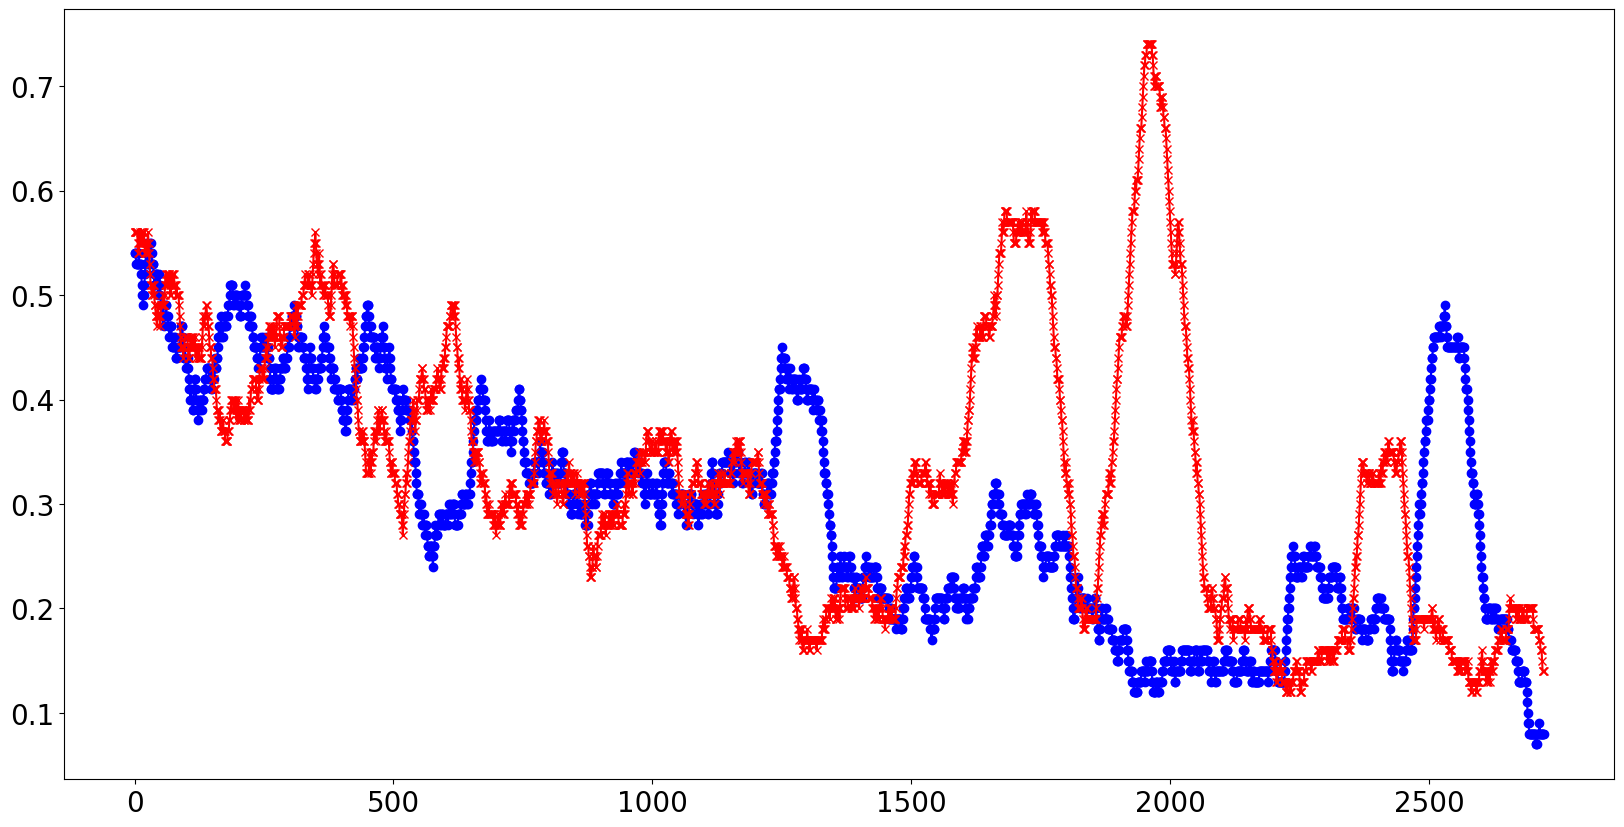

In [88]:
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w
plt.rcParams["figure.figsize"] = (20, 10)
plt.rcParams['font.size']=20
plt.plot(moving_average(np.array(actions)[:,0],100), label = 'Agent 1 Actions', marker = 'o', c = 'b')
plt.plot(moving_average(np.array(actions)[:,1],100), label = 'Agent 2 Actions', marker = 'x', c = 'r')
#plt.title('Fraction of Co-operations in 100 games') 
plt.show()

- Almost immediately the value of C is recognized
- Gradually both end up at (C,C)
- No discounting